<div class='bar_title'></div>

*Data Driven Decisions (D3) in Practice: Urban Analytics - Predicting AirBnB Prices*

# 2. Handling Spatial Data in Python

__Gunther Gust__ <br>
Chair for Enterprise AI <br>
Data Driven Decisions Group <br>
Center for Artificial Intelligence and Data Science (CAIDAS)

<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

In this lecture, we will learn how to load, manipulate and visualize spatial data. In some senses, spatial data are usually included simply as "one more column" in a table. However, *spatial is special* sometimes and there are few aspects in which geographic data differ from standard numerical tables. In this session, we will extend the skills developed in the [previous one](../bB/lab_B) about non-spatial data, and combine them. In the process, we will discover that, although with some particularities, dealing with spatial data in Python largely resembles dealing with non-spatial data.

## Content

- PART a) Spatial Data Types and Plotting
- Part b) Performing Spatial Computations
- Part c) Kernel Density Estimation (KDE)

*Credits: Much of the material is taken from [Arribas-Bel, Geographic Data Science](https://darribas.org/gds_course/content/home.html#)*

# PART a) Spatial Data Types and Plotting

## Loading spatial data

In [45]:
import numpy as np
import geopandas
import osmnx
import contextily as cx

import matplotlib.pyplot as plt
import mapclassify
import seaborn 

import geodatasets

osmnx.settings.overpass_settings='[out:json][timeout:90][date:"2020-09-07T00:00:00Z"]'

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

## Polygons (e.g. Cities)


*This dataset is derived from {cite}`arribas2019building`, which proposes a machine learning algorithm to delineate city boundaries from building footprints.*


First we will use a polygon geography. We will use an open dataset that contains the boundaries of Spanish cities. We can read it into an object named `cities` by:

In [4]:
cities = geopandas.read_file("https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/spanish_cities.gpkg")

`geopandas.read_file()` supports a wide range of geospatial file formats. Some of the common geospatial file formats that `geopandas.read_file()` can handle include:

- Shapefiles (.shp)
- GeoJSON (.geojson)
- GeoPackage (.gpkg)
- KML (.kml)
- ESRI File Geodatabase (.gdb)
- MapInfo TAB (.tab)
- TopoJSON (.topojson)
- Comma-Separated Values (CSV) with geometry information
- ...

## Lines (e.g. Streets)

*This dataset froms of a project called "Las calles de las mujeres", a community-driven initiative exploring the extent to which streets are named after women.* 

*Check out more about the project, including an interactive map at:
> [https://geochicasosm.github.io/lascallesdelasmujeres/](https://geochicasosm.github.io/lascallesdelasmujeres/)


And you can read it into an object called `streets` with:

In [5]:
streets = geopandas.read_file("https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/final_tile.geojson")

## Points (e.g. Bars)

The final dataset we will rely on is a set of points demarcating the location of bars in Madrid. To obtain it, we will use `osmnx`, a Python library that allows us to query [OpenStreetMap](https://www.openstreetmap.org). Note that we use the method `features_from_place`, which queries for points of interest (POIs, or `pois`) in a particular place (Madrid in this case). In addition, we can specify a set of tags to delimit the query. We use this to ask _only_ for amenities of the type "bar":

In [6]:
pois = osmnx.features_from_address(
    "Madrid, Spain", dist = 30000, tags={"amenity": "bar"}
)

You do not need to know at this point what happens behind the scenes when we run `features_from_place` but, if you are curious, we are making a query to [OpenStreetMap](https://www.openstreetmap.org) (almost as if you typed "bars in Madrid, Spain" within Google Maps) and getting the response as a table of data, instead of as a website with an interactive map. Pretty cool, huh?

## Inspecting and plotting spatial data

The most direct way to get from a file to a quick visualization of the data is by loading it as a `GeoDataFrame` and calling the `plot` command. The main library employed for all of this is `geopandas` which is a geospatial extension of the `pandas` library, already introduced before. `geopandas` supports the same functionality that `pandas` does, plus a wide range of spatial extensions that make manipulation and general "munging" of spatial data similar to non-spatial tables.


In two lines of code, we will obtain a graphical representation of the spatial data contained in a file that can be in many formats; actually, since it uses the same drivers under the hood, you can load pretty much the same kind of vector files that Desktop GIS packages like QGIS permit. Let us start by plotting single layers in a crude but quick form, and we will build style and sophistication into our plots later on.

### Polygons

`cities` is a `GeoDataFrame`. Very similar to a traditional, non-spatial `DataFrame`, but with an additional column called `geometry`:

In [7]:
cities.head()

city_id  n_buildings                                           geometry
0   ci000         2348  POLYGON ((385390.071 4202949.446, 384488.697 4...
1   ci001         2741  POLYGON ((214893.033 4579137.558, 215258.185 4...
2   ci002         5472  POLYGON ((690674.281 4182188.538, 691047.526 4...
3   ci003        14608  POLYGON ((513378.282 4072327.639, 513408.853 4...
4   ci004         2324  POLYGON ((206989.081 4129478.031, 207275.702 4...

This allows us to quickly produce a plot by executing the following line:

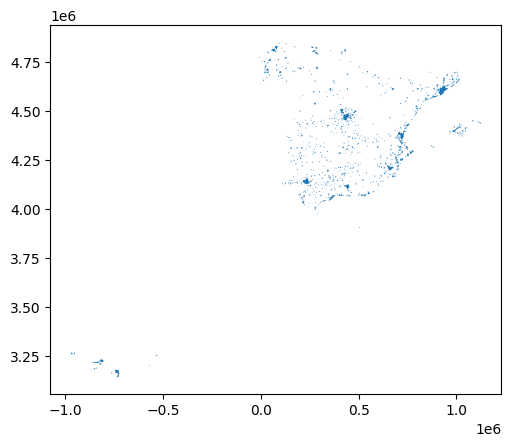

In [8]:
cities.plot();

This might not be the most aesthetically pleasant visual representation of the Cities geography, but it is hard to argue it is not quick to produce. We will work on styling and customizing spatial plots later on.

**Pro-tip**: if you call a single row of the `geometry` column, it'll return a small plot ith the shape:

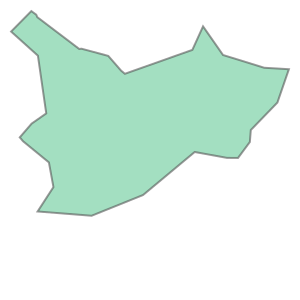

In [9]:
cities.loc[0, 'geometry']

### Lines

Similarly to the polygon case, if we pick the `"geometry"` column of a table with lines, a single row will display the geometry as well:

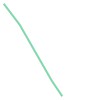

In [10]:
streets.loc[100, 'geometry']

A quick plot is similarly generated by:

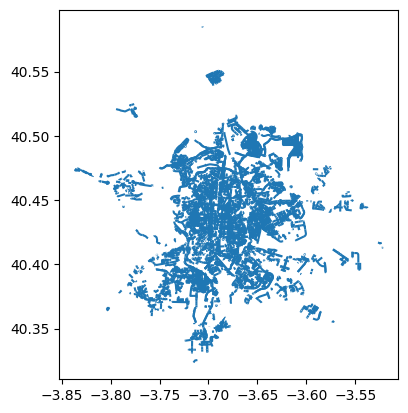

In [11]:
streets.plot();

Again, this is not the prettiest way to display the streets maybe, and you might want to change a few parameters such as colors, etc. All of this is possible, as we will see below, but this gives us a quick check of what lines look like.

### Points

Points take a similar approach for quick plotting:

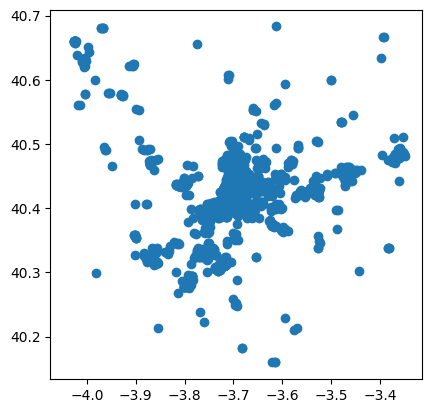

In [12]:
pois.plot();

## Styling plots

It is possible to tweak several aspects of a plot to customize if to particular needs. In this section, we will explore some of the basic elements that will allow us to obtain more compelling maps.



**NOTE**: some of these variations are very straightforward while others are more intricate and require tinkering with the internal parts of a plot. They are not necessarily organized by increasing level of complexity.

### Changing transparency

The intensity of color of a polygon can be easily changed through the `alpha` attribute in plot. This is specified as a value betwee zero and one, where the former is entirely transparent while the latter is the fully opaque (maximum intensity):

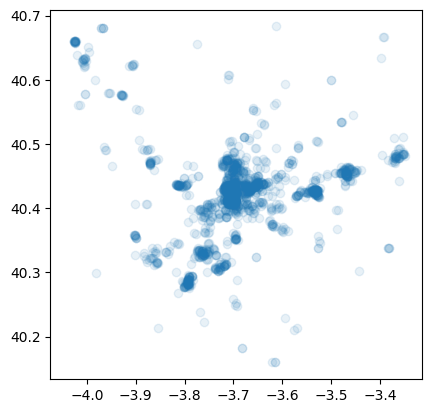

In [13]:
pois.plot(alpha=0.1);

### Removing axes

Although in some cases, the axes can be useful to obtain context, most of the times maps look and feel better without them. Removing the axes involves wrapping the plot into a figure, which takes a few more lines of aparently useless code but that, in time, it will allow you to tweak the map further and to create much more flexible designs:

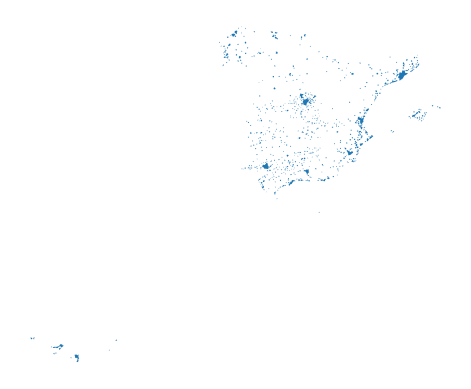

In [14]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Plot layer of polygons on the axis
ax = cities.plot(ax=ax)
# Remove axis frames
ax.set_axis_off()
# Display
plt.show()

Let us stop for a second a study each of the previous lines:

1. We have first created a figure named `f` with one axis named `ax` by using the command `plt.subplots` (part of the library `matplotlib`, which we have imported at the top of the notebook). Note how the method is returning two elements and we can assign each of them to objects with different name (`f` and `ax`) by simply listing them at the front of the line, separated by commas.
1. Second, we plot the geographies as before, but this time we tell the function that we want it to draw the polygons on the axis we are passing, `ax`. This method returns the axis with the geographies in them, so we make sure to store it on an object with the same name, `ax`.
1. On the third line, we effectively remove the box with coordinates.
1. Finally, we draw the entire plot by calling `plt.show()`.

### Adding titles

Adding a title is an extra line, if we are creating the plot within a figure, as we just did. To include text on top of the figure:

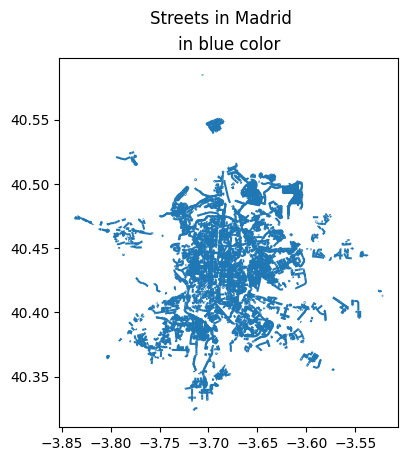

In [15]:
# Setup figure and axis
f2, ax2 = plt.subplots(1)
# Add layer of polygons on the axis
ax2 = streets.plot(ax=ax2)
# Add figure title ("sup" refers to "super", meaning the title of the superordinate figure)
f2.suptitle("Streets in Madrid")
# you can also add a title to the axes
ax2.set_title("in blue color")
# Display
plt.show()

### Changing the size of the map

The size of the plot is changed equally easily in this context. The only difference is that it is specified when we create the figure with the argument `figsize`. The first number represents the width, the X axis, and the second corresponds with the height, the Y axis.

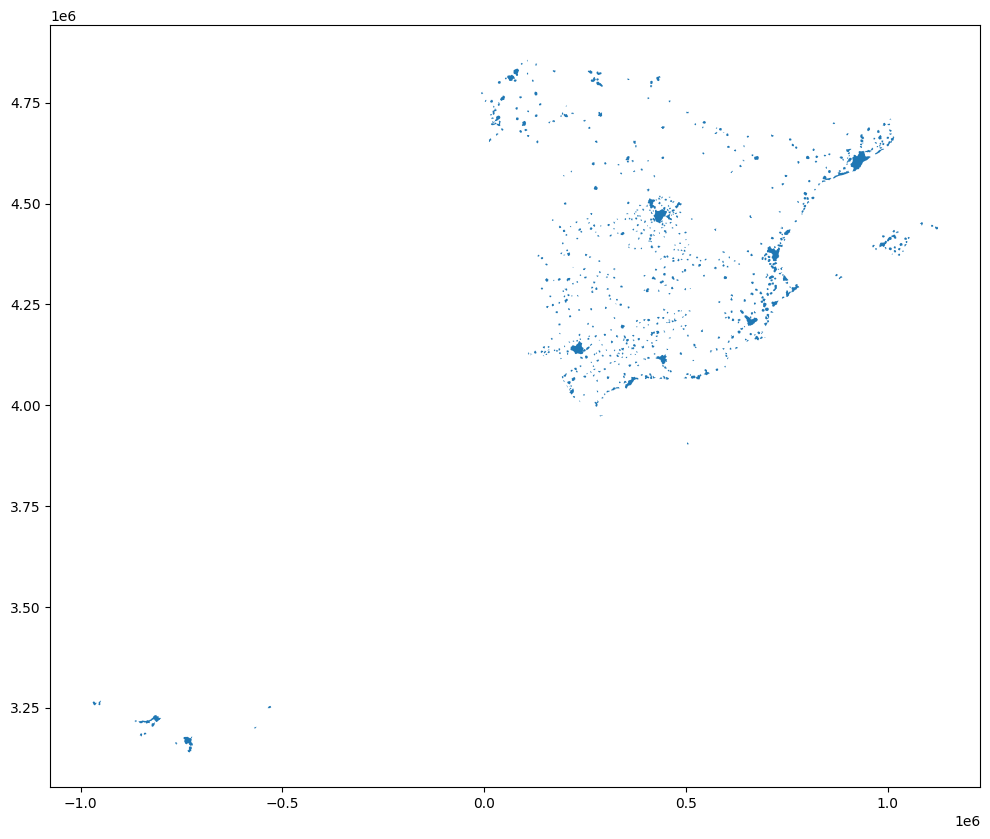

In [16]:
# Setup figure and axis with different size
f3, ax3 = plt.subplots(1, figsize=(12, 12))
# Add layer of polygons on the axis
cities.plot(ax=ax3)
# Display
plt.show()

### Modifying borders of polygons

Border lines sometimes can distort or impede proper interpretation of a map. In those cases, it is useful to know how they can be modified. Although not too complicated, the way to access borders in `geopandas` is not as straightforward as it is the case for other aspects of the map, such as size or frame. Let us first see the code to make the *lines thicker* and *black*, and then we will work our way through the different steps:

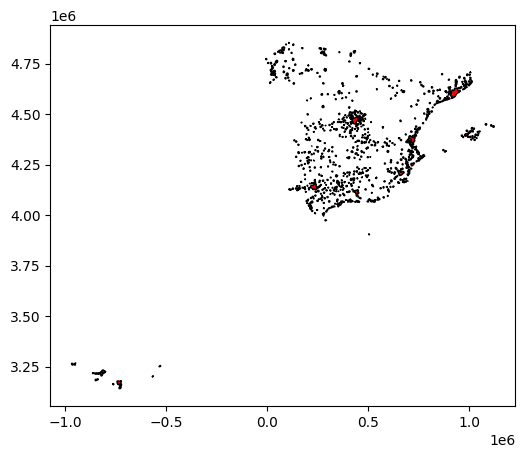

In [17]:
# Setup figure and axis
f4, ax4 = plt.subplots(1, figsize=(6, 6))
# Add layer of polygons on the axis, set fill color (`facecolor`) and boundary
# color (`edgecolor`)
cities.plot(
    linewidth=1, 
    facecolor='red', 
    edgecolor='black', 
    ax=ax4
);

Note how the lines are thicker. In addition, all the polygons are colored in the same (default) color, light red. However, because the lines are thicker, we can only see the polygon filling for those cities with an area large enough.

Let us examine line by line what we are doing in the code snippet:

* We begin by creating the figure (`f`) object and one axis inside it (`ax`) where we will plot the map.
* Then, we call `plot` as usual, but pass in two new arguments: `linewidth` for the width of the line; `facecolor`, to control the color each polygon is filled with; and `edgecolor`, to control the color of the boundary.


This approach works very similarly with other geometries, such as lines. For example, if we wanted to plot the streets in red, we would simply:

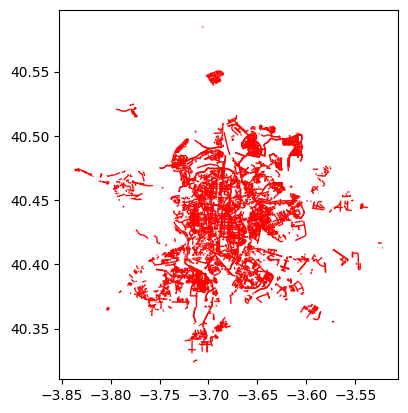

In [18]:
# Setup figure and axis
f, ax5 = plt.subplots(1)
# Add layer with lines, set them red and with different line width
# and append it to the axis `ax5`
ax5 = streets.plot(linewidth=1, color='red', ax=ax5)
plt.show()

Important, note that in the case of lines the parameter to control the color is simply `color`. This is because lines do not have an area, so there is no need to distinguish between the main area (`facecolor`) and the border lines (`edgecolor`).


### Transforming CRS

The coordindate reference system (CRS) is the way geographers and cartographers have to represent a three-dimentional object, such as the round earth, on a two-dimensional plane, such as a piece of paper or a computer screen. If the source data contain information on the CRS of the data, we can modify this in a `GeoDataFrame`. First let us check if we have the information stored properly:

In [19]:
cities.crs

<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

As we can see, there is information stored about the reference system: it is using the standard Spanish projection, which is expressed in meters. There are also other less decipherable parameters but we do not need to worry about them right now.


If we want to modify this and "reproject" the polygons into a different CRS, the quickest way is to find the [EPSG](https://en.wikipedia.org/wiki/International_Association_of_Oil_%26_Gas_Producers#European_Petroleum_Survey_Group) code online ([epsg.io](http://epsg.io/) is a good one, although there are others too). For example, if we wanted to transform the dataset into lat/lon coordinates, we would use its EPSG code, 4326:

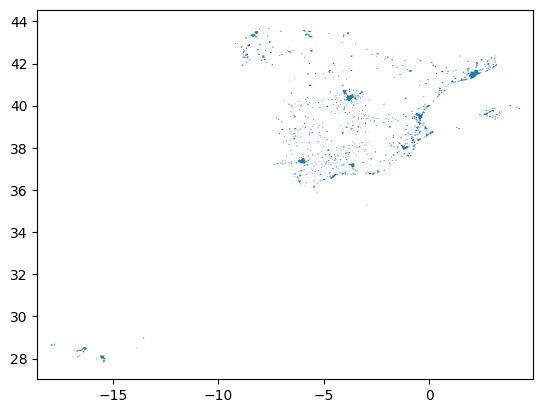

In [20]:
# Reproject (`to_crs`) and plot (`plot`) polygons
cities.to_crs(epsg=4326).plot()
# Set equal axis
lims = plt.axis('equal')

The shape of the polygons is slightly different. Furthermore, note how the *scale* in which they are plotted differs.

## Composing multi-layer maps

So far we have considered many aspects of plotting *a single* layer of data. However, in many cases, an effective map will require more than one: for example we might want to display streets on top of the polygons of neighborhoods, and add a few points for specific locations we want to highlight. At the very heart of GIS is the possibility to combine spatial information from different sources by overlaying it on top of each other, and this is fully supported in Python.

For this section, let's select only Madrid from the `cities` table and convert it to lat/lon so it's aligned with the `streets` and `POI`s layers:

In [21]:
mad = cities.loc[[12], :].to_crs(epsg=4326)
mad

city_id  n_buildings                                           geometry
12   ci012       193714  POLYGON ((-3.90016 40.30421, -3.90019 40.30457...

Combining different layers on a single map boils down to adding each of them to the same axis in a sequential way, as if we were literally overlaying one on top of the previous one. For example, let's plot the boundary of Madrid and its bars:

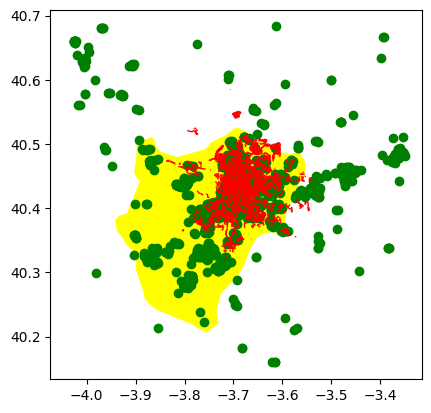

In [22]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")
# Add streets
streets.plot(ax=ax, color = "red", linewidth=1)

plt.show()

## Saving maps to figures

Once we have produced a map we are content with, we might want to save it to a file so we can include it into a report, article, website, etc. Exporting maps in Python involves replacing `plt.show` by `plt.savefig` at the end of the code block to specify where and how to save it. For example to save the previous map into a `png` file in the same folder where the notebook is hosted:

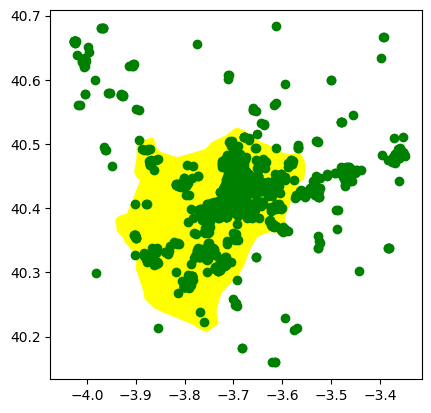

In [23]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")
# Save figure to a PNG file
plt.savefig('madrid_bars.png')

If you now check on the folder, you'll find a `png` (image) file with the map.

### Tweaking parameters: resolution

The command `plt.savefig` contains a large number of options and additional parameters to tweak. Given the size of the figure created is not very large, we can increase this with the argument `dpi`, which stands for "dots per inch" and it's a standard measure of resolution in images. For example, for a high quality image, we could use 500:

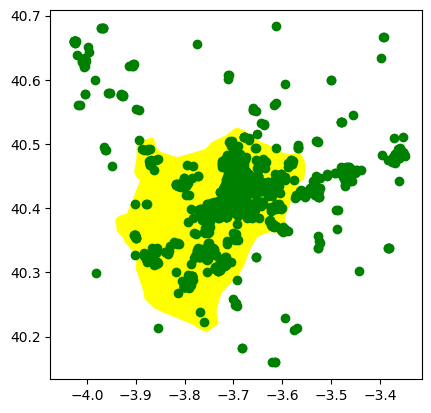

In [24]:
# Setup figure and axis
f, ax = plt.subplots(1)
# Add a layer with polygon on to axis `ax`
mad.plot(ax=ax, color="yellow")
# Add a layer with lines on top in axis `ax`
pois.plot(ax=ax, color="green")
# Save figure to a PNG file
plt.savefig('madrid_bars_high_res.png', dpi=500)

## Adding base layers from web sources

Many single datasets lack context when displayed on their own. A common approach to alleviate this is to use web tiles, which are a way of quickly obtaining geographical context to present spatial data. In Python, we can use [`contextily`](https://contextily.readthedocs.io) to pull down tiles and display them along with our own geographic data.

We create a map in the same way we would do normally, and then use the `add_basemap` command to, er, add a basemap:

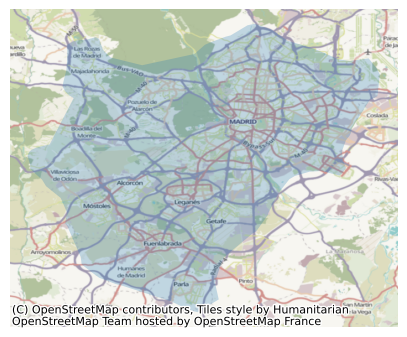

In [25]:
f, ax = plt.subplots(1, figsize=(5, 5))
mad.plot(alpha=0.25, ax=ax)
cx.add_basemap(ax, crs=mad.crs)
ax.set_axis_off()

Note that we need to be explicit when adding the basemap to state the coordinate reference system (`crs`) our data is expressed in, `contextily` will not be able to pick it up otherwise.

Now, `contextily` offers a lot of options in terms of the sources and providers you can use to create your basemaps. For example, we can use satellite imagery instead:

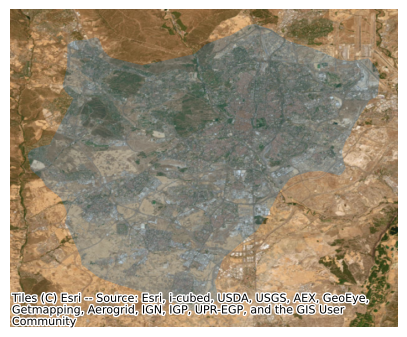

In [26]:
f, ax = plt.subplots(1, figsize=(5, 5))
mad.plot(alpha=0.25, ax=ax)
cx.add_basemap(
    ax, 
    crs=mad.crs,
    source=cx.providers.Esri.WorldImagery
)
ax.set_axis_off()

For more basemaps, check out the documentation website for the package:

> [https://contextily.readthedocs.io/en/latest/](https://contextily.readthedocs.io/en/latest/)

## Interactive maps

Everything we have seen so far relates to static maps. These are useful for publication, to include in reports or to print. However, modern web technologies afford much more flexibility to explore spatial data interactively.


We will use the state-of-the-art Leaflet integration into `geopandas`. This integration connects `GeoDataFrame` objects with the popular web mapping library Leaflet.js. In this context, we will only show how you can take a `GeoDataFrame` into an interactive map in one line of code:

In [29]:
# Display interactive map
streets.explore()

# Part b) Performing spatial computations on `GeoDataFrames`

## Spatial Joins

In a spatial join, two geometry objects are merged based on their spatial relationship to one another. GeoPandas provides two spatial-join functions:
* `GeoDataFrame.sjoin()`: joins based on binary predicates (intersects, contains, etc.)
* `GeoDataFrame.sjoin_nearest()`: joins based on proximity, with the ability to set a maximum search radius.

The following is adapted from the [geopandas documentation](https://geopandas.org/en/stable/docs/user_guide/mergingdata.html).

Example: Count how many grocery stores are in each district of Chicago 

In [30]:
chicago = geopandas.read_file(geodatasets.get_path("geoda.chicago_commpop"))
groceries = geopandas.read_file(geodatasets.get_path("geoda.groceries"))

chicago = chicago[['geometry', 'community']].to_crs(groceries.crs)

Extracting 'chicago_commpop/chicago_commpop.geojson' from '/home/vscode/.cache/geodatasets/chicago_commpop.zip' to '/home/vscode/.cache/geodatasets/chicago_commpop.zip.unzip'
Extracting 'grocery/chicago_sup.shp' from '/home/vscode/.cache/geodatasets/grocery.zip' to '/home/vscode/.cache/geodatasets/grocery.zip.unzip'
Extracting 'grocery/chicago_sup.dbf' from '/home/vscode/.cache/geodatasets/grocery.zip' to '/home/vscode/.cache/geodatasets/grocery.zip.unzip'
Extracting 'grocery/chicago_sup.shx' from '/home/vscode/.cache/geodatasets/grocery.zip' to '/home/vscode/.cache/geodatasets/grocery.zip.unzip'
Extracting 'grocery/chicago_sup.prj' from '/home/vscode/.cache/geodatasets/grocery.zip' to '/home/vscode/.cache/geodatasets/grocery.zip.unzip'


In [31]:
groceries.head()

OBJECTID     Ycoord     Xcoord Status  \
0        16  41.973266 -87.657073   OPEN   
1        18  41.696367 -87.681315   OPEN   
2        22  41.868634 -87.638638   OPEN   
3        23  41.877590 -87.654953   OPEN   
4        27  41.737696 -87.625795   OPEN   

                                        Address               Chain Category  \
0          1051 W ARGYLE ST, CHICAGO, IL. 60640      VIET HOA PLAZA     None   
1  10800 S WESTERN AVE, CHICAGO, IL. 60643-3226   COUNTY FAIR FOODS     None   
2      1101 S CANAL ST, CHICAGO, IL. 60607-4932  WHOLE FOODS MARKET     None   
3  1101 W JACKSON BLVD, CHICAGO, IL. 60607-2905        TARGET/SUPER      new   
4        112 W 87TH ST, CHICAGO, IL. 60620-1318         FOOD 4 LESS     None   

                               geometry  
0  MULTIPOINT (1168268.672 1933554.350)  
1  MULTIPOINT (1162302.618 1832900.224)  
2  MULTIPOINT (1173317.042 1895425.426)  
3  MULTIPOINT (1168996.475 1898801.406)  
4  MULTIPOINT (1176991.989 1847262.423)

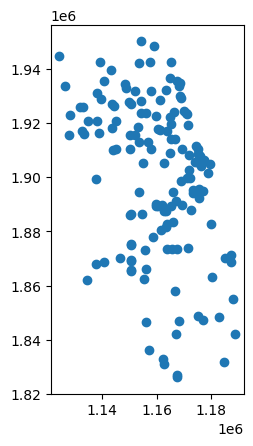

In [32]:
groceries.plot();

In [33]:
chicago.head()

geometry        community
0  MULTIPOLYGON (((1181573.250 1886828.039, 11815...          DOUGLAS
1  MULTIPOLYGON (((1186289.356 1876750.733, 11862...          OAKLAND
2  MULTIPOLYGON (((1176344.998 1871187.546, 11763...      FULLER PARK
3  MULTIPOLYGON (((1182322.043 1876674.730, 11823...  GRAND BOULEVARD
4  MULTIPOLYGON (((1186289.356 1876750.733, 11862...          KENWOOD

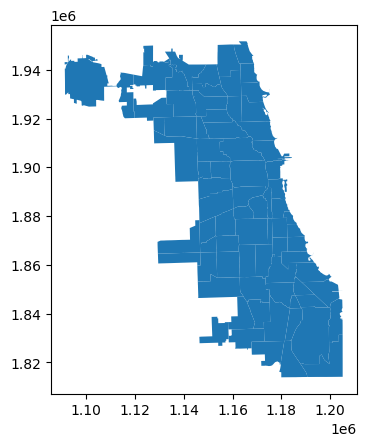

In [34]:
chicago.plot();

Perform spatial join

In [35]:
groceries_with_community = groceries.sjoin(chicago, how="left", predicate='intersects')
groceries_with_community.head()

OBJECTID     Ycoord     Xcoord Status  \
0        16  41.973266 -87.657073   OPEN   
1        18  41.696367 -87.681315   OPEN   
2        22  41.868634 -87.638638   OPEN   
3        23  41.877590 -87.654953   OPEN   
4        27  41.737696 -87.625795   OPEN   

                                        Address               Chain Category  \
0          1051 W ARGYLE ST, CHICAGO, IL. 60640      VIET HOA PLAZA     None   
1  10800 S WESTERN AVE, CHICAGO, IL. 60643-3226   COUNTY FAIR FOODS     None   
2      1101 S CANAL ST, CHICAGO, IL. 60607-4932  WHOLE FOODS MARKET     None   
3  1101 W JACKSON BLVD, CHICAGO, IL. 60607-2905        TARGET/SUPER      new   
4        112 W 87TH ST, CHICAGO, IL. 60620-1318         FOOD 4 LESS     None   

                               geometry  index_right       community  
0  MULTIPOINT (1168268.672 1933554.350)           30          UPTOWN  
1  MULTIPOINT (1162302.618 1832900.224)           73     MORGAN PARK  
2  MULTIPOINT (1173317.042 1895425.426)           28  NEAR WEST SIDE  
3  MULTIPOINT (1168996.475 1898801.406)           28  NEAR WEST SIDE  
4  MULTIPOINT (1176991.989 1847262.423)           39         CHATHAM

`GeoDataFrame.sjoin()` has two core arguments: __how__ and __predicate__:

The **how** argument specifies the type of join that will occur and which geometry is retained in the resultant GeoDataFrame. It accepts the following options:

* *left*: use the index from the first (or left_df) GeoDataFrame that you provide to GeoDataFrame.sjoin(); retain only the left_df geometry column

* *right*: use index from second (or right_df); retain only the right_df geometry column

* *inner*: use intersection of index values from both GeoDataFrame; retain only the left_df geometry column

Note more complicated spatial relationships can be studied by combining geometric operations with spatial join. To find all polygons within a given distance of a point, for example, one can first use the buffer() method to expand each point into a circle of appropriate radius, then intersect those buffered circles with the polygons in question.

The __predicate__ argument specifies how GeoPandas decides whether or not to join the attributes of one object to another, based on their geometric relationship. The values for predicate correspond to the names of geometric binary predicates and depend on the spatial index implementation.

The default spatial index in GeoPandas currently supports the following values for predicate which are defined in the [Shapely](https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates) documentation: 
* intersects
* contains
* within
* touches
* crosses
* overlaps

Count the number of groceries in each community

In [36]:
grocery_count = groceries_with_community.groupby('community').size()
grocery_count[:5]

community
ALBANY PARK       1
ARCHER HEIGHTS    2
ARMOUR SQUARE     1
ASHBURN           1
AUBURN GRESHAM    1
dtype: int64

In [37]:
#convert series into dataframe
grocery_count_df = grocery_count.reset_index(name="size")

#add results as new column to chicago geodataframe
community_groceries = chicago.merge(grocery_count_df, on="community", how="left")

#add zeros for communities without groceries
community_groceries["size"] = community_groceries["size"].fillna(0)
community_groceries.head()


geometry        community  size
0  MULTIPOLYGON (((1181573.250 1886828.039, 11815...          DOUGLAS   1.0
1  MULTIPOLYGON (((1186289.356 1876750.733, 11862...          OAKLAND   0.0
2  MULTIPOLYGON (((1176344.998 1871187.546, 11763...      FULLER PARK   0.0
3  MULTIPOLYGON (((1182322.043 1876674.730, 11823...  GRAND BOULEVARD   0.0
4  MULTIPOLYGON (((1186289.356 1876750.733, 11862...          KENWOOD   0.0

Plot the results

In [38]:
import mapclassify

<Axes: >

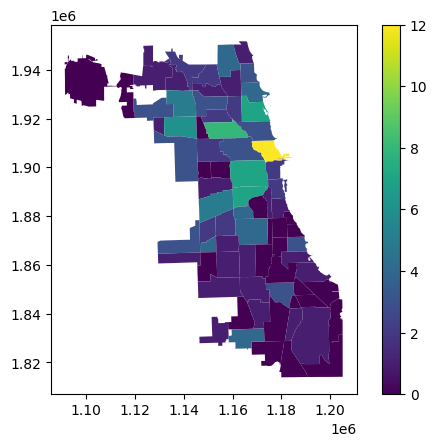

In [39]:
#create a choropleth plot
community_groceries.plot(column="size", legend=True)

### Nearest joins

Proximity-based joins can be done via `GeoDataFrame.sjoin_nearest()`. `GeoDataFrame.sjoin_nearest()` shares the how argument with `GeoDataFrame.sjoin()`, and includes two additional arguments: __max_distance__ and __distance_col__:

* _max_distance_: The max_distance argument specifies a maximum search radius for matching geometries. This can have a considerable performance impact in some cases. If you can, it is highly recommended that you use this parameter.
* _distance_col_: If set, the resultant GeoDataFrame will include a column with this name containing the computed distances between an input geometry and the nearest geometry.

# Part c) Kernel density estimation

Example: What is the density of groceries at arbitrary locations?

### 1. Extract the coordinates of the grocery stores

In [40]:
# Initialize lists to store x and y values
x_values = []
y_values = []

# Iterate through each row in the GeoDataFrame
for multipoint in groceries.geometry:
    # Ensure the geometry is indeed MultiPoint; if it's just a single Point, wrap it in a list
    points = list(multipoint.geoms) if hasattr(multipoint, "geoms") else [multipoint]
    
    # For each Point in the MultiPoint, extract x and y values
    for point in points:
        x_values.append(point.x)
        y_values.append(point.y)

# Optionally, convert the lists to numpy arrays for further processing
x_values = np.array(x_values)
y_values = np.array(y_values)

### 2. Compute the kernel density estimation

In [41]:
from scipy.stats import gaussian_kde

# Rearrange data to create a 2D array of x and y coordinates
xy = np.vstack([x_values,y_values])

# Compute the density estimation
kde = gaussian_kde(xy)

# Define the grid points where you want to calculate the density
xmin, xmax = x_values.min(), x_values.max()
ymin, ymax = y_values.min(), y_values.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] #generate 100 evenly spaced points between min and max

# Evaluate the density at grid points
density = kde(np.vstack([xx.ravel(), yy.ravel()]))
density = density.reshape(xx.shape) # reshape to the original shape of xx (for plotting)

### 3. Plot the results

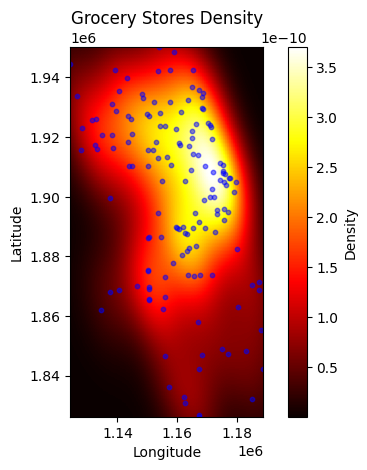

In [42]:
plt.imshow(np.rot90(density), cmap='hot', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label='Density')
plt.scatter(x_values, y_values, s=10, c='blue', alpha=0.5)
plt.title('Grocery Stores Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## KDE Plot using the 'seaborn' package

If you only want to create a kernel density plot, you can use the `kdeplot()` function of the  `seaborn` package:

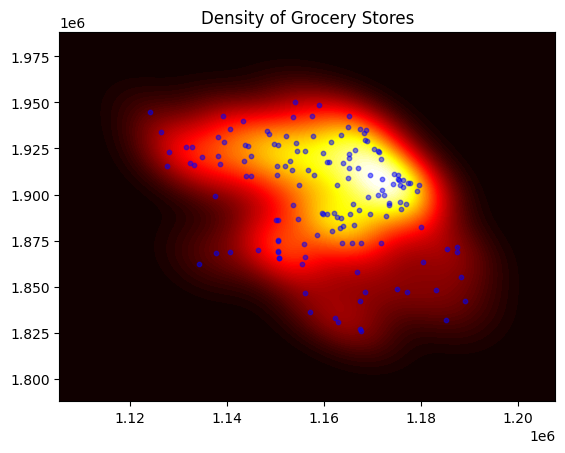

In [43]:
seaborn.kdeplot(x = x_values, y=y_values, fill=True, thresh=0, levels=100, cmap="hot")
plt.scatter(x_values, y_values, s=10, c='blue', alpha=0.5)
plt.title('Density of Grocery Stores')
plt.show()

## Further resources


### Spatial Operations

More advanced GIS operations are possible in `geopandas` and, in most cases, they are extensions of the same logic we have used in this document. If you are thinking about taking the next step from here, the following operations (and the documentation provided) will give you the biggest ["bang for the buck"](https://en.wikipedia.org/wiki/Bang_for_the_buck):


* **Spatial overlays**: create new shapes based on places where two datasets overlap (or don’t overlap)

> [https://geopandas.org/set_operations.html](https://geopandas.org/set_operations.html)

### Creating Maps

* **[Geoplot](https://residentmario.github.io/geoplot/index.html)** is a great python package for making spatial plots (going beyond of what we covered)

* **[Kepler](https://kepler.gl/)** is a great tool to quickly create and explore maps via drag-and-drop

### Kernel Density Estimation

* **[The Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)** has a great section on KDE, including on how to set and tune kernel bandwiths

<img src="images/d3.png" style="width:50%; float:center;" />